In [1]:
import pandas as pd 
from os import listdir
import seaborn as sns
sns.set()

In [2]:
# Read csv filenames 
files = [name for name in listdir() if 'csv' in name]
fileName = files[0]
fileName = '866192035974276_AXIO.csv'

In [3]:
# Read a file as dataframe 
df = pd.read_csv(fileName)

# Drop all Unnamed Columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Available columns 
df.columns.values

#Check Datatypes 
df.dtypes

list                     int64
id                       int64
receive_time            object
velocity               float64
engine_status            int64
main_battery_status      int64
ac_status                int64
voltage                  int64
satellite_number         int64
gps_availability         int64
gsm_strength             int64
row_status               int64
created_at              object
latitude_degree        float64
longitude_degree       float64
travel_distance_km     float64
fuel_litre             float64
fuel_type                int64
fuel_stability           int64
dtype: object

In [4]:
# Fixing the datatype 
df['receive_time'] = pd.to_datetime(df['receive_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

In [5]:
df.head()

,list,id,receive_time,velocity,engine_status,main_battery_status,ac_status,voltage,satellite_number,gps_availability,gsm_strength,row_status,created_at,latitude_degree,longitude_degree,travel_distance_km,fuel_litre,fuel_type,fuel_stability
0,0,1,2018-03-02 10:23:57,0.0,0,1,0,9117,18,1,29,1,2018-03-02 10:23:57,23.82404,90.4181,0.0,0.0,0,0
1,1,2,2018-03-02 10:24:02,0.0,0,1,0,9117,18,1,29,1,2018-03-02 10:24:02,23.82404,90.4181,0.0,0.0,0,0
2,2,3,2018-03-02 10:24:07,0.0,0,1,0,9117,18,1,29,1,2018-03-02 10:24:07,23.82404,90.4181,0.0,0.0,0,0
3,3,4,2018-03-02 10:24:12,0.0,0,1,0,9117,18,1,29,1,2018-03-02 10:24:12,23.82404,90.4181,0.0,0.0,0,0
4,4,5,2018-03-02 10:24:17,0.0,0,1,0,9117,18,1,29,1,2018-03-02 10:24:17,23.82404,90.4181,0.0,0.0,0,0


In [6]:
# Create New Columns to find Time_difference_between_consecutive_creation_of_data
df['time_difference'] = df['created_at'] - df['created_at'].shift()

# Convert time difference to seconds 
df['time_difference'] = df['time_difference'].dt.total_seconds()

# Create New Columns - diff between fuel_data
df['fuel_difference'] = df['fuel_litre'] - df['fuel_litre'].shift()

# Difference Between voltages 
df['voltage_difference'] = df['voltage'] - df['voltage'].shift()

In [7]:
# Drop the rows with NAN values 
df = df.dropna(axis=0, how='any')
df = df.loc[df['fuel_litre'] < 40 ]
df = df.loc[df['fuel_litre'] > 4 ]

In [8]:
df['travel_distance_km'].corr(df['fuel_difference'])

-0.007896869347586006

Populating the interactive namespace from numpy and matplotlib


/home/clueless/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


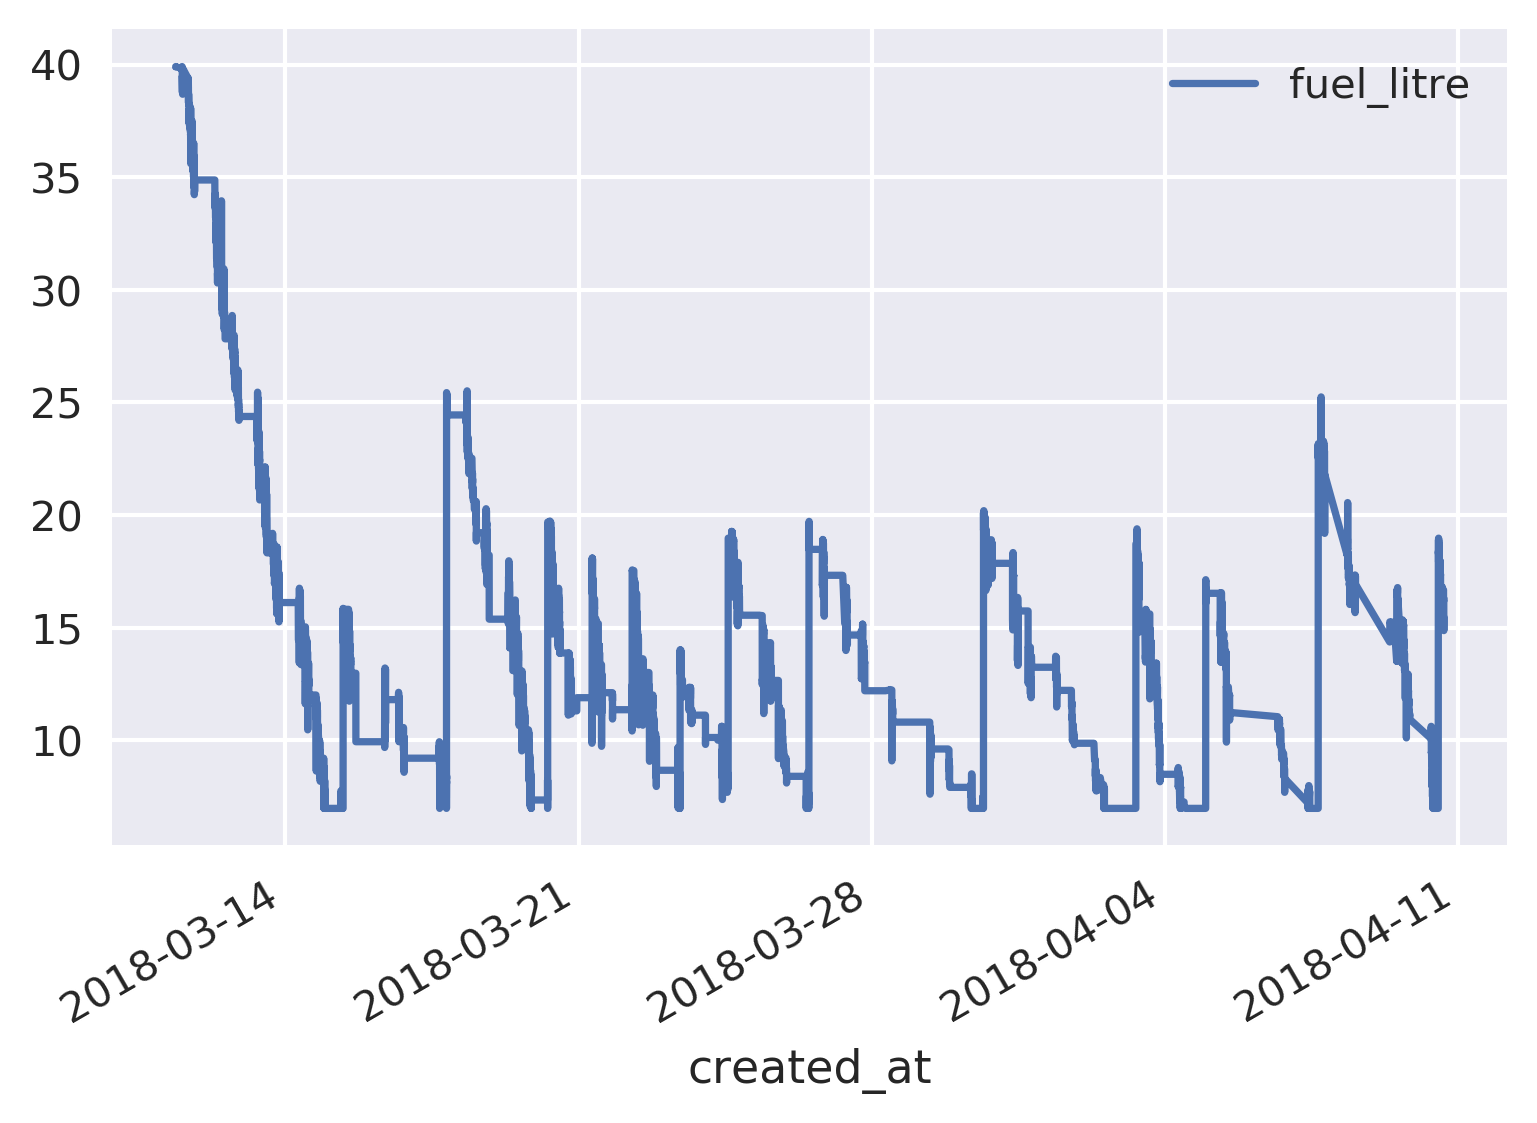

In [9]:
%pylab inline 
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
def standardize(series):
    return (series - series.mean())/series.std(ddof=0)
len(standardize(df['voltage']))
df.plot(x = 'created_at',y=['fuel_litre'])

In [10]:
# eng = np.array(df['engine_status'])
# for i,en in enumerate(eng):
#     if i>0 and eng[i] == 1 and eng[i-1] ==0:
#         print(df['fuel_litre'][i:i+10].var())
#         var = df['fuel_litre'][i:i+100].var()
#         print('column: '+str(i))
#         if .5<var<1:
            
#             print('refill')

In [11]:
df['fuel_litre'][1:10].var()

0.0

In [12]:
## Applying kalman Filter 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import namedtuple 
from ipywidgets import interact

# mpl.rcParams['figure.figsize'] = (20,10)

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, š={:.3f})'.format(s[0], s[1])


fuel = np.array(df['fuel_litre'])
engine = np.array(df['engine_status'])

#fuel = np.flip(fuel, axis=0)

# plt.plot(fuel)

def gaussian_multiply(g1,g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean)/(g1.var+g2.var)
    variance = (g1.var*g2.var)/(g1.var+g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)


def kf_apply(SensorVarNoise, ProcessVarNoise, SensorVarClean, ProcessVarClean):
    sensor_var_noise = SensorVarNoise**2
    process_var_noise = ProcessVarNoise**2
    sensor_var_clean = SensorVarClean**2
    process_var_clean = ProcessVarClean**2

    process_var = 0.01
    sensor_var = 50.**2 	#SD 50 - 68% of values will be within X +/- 50 
    velocity = 0
    dt = 1.

    process_model = gaussian(velocity*dt, process_var)

    x = gaussian(fuel[0], 50**2)
    updated = []
    loop = 0
    m = fuel[0]
    for i,z in enumerate(fuel):
        curr_eng = engine[i]
        prev_eng = engine[i-1]
        if curr_eng - prev_eng == 1 and z-m>4:
            if 0.0 < np.var(fuel[i:i+10]) < 0.5:
                loop = 10
        if loop > 0:
            sensor_var = sensor_var_noise
            process_var = process_var_noise
            loop -= 1
        elif loop == 0:
            sensor_var = sensor_var_clean
            process_var = process_var_clean
            
        process_model = gaussian(velocity*dt, process_var)
        prior = predict(x, process_model)
        likelihood = gaussian(z, sensor_var)
        x = update(prior, likelihood)
        m,s = x 
        updated.append(m)

    # plt.hold()
    plt.plot(updated)
    
interact(kf_apply,SensorVarNoise=(0.0,50.0,2),ProcessVarNoise=(0.0,50.0,5),SensorVarClean=(1.0,50.0,5),ProcessVarClean=(0.01,0.1,0.01))

interactive(children=(FloatSlider(value=24.0, description='SensorVarNoise', max=50.0, step=2.0), FloatSlider(value=25.0, description='ProcessVarNoise', max=50.0, step=5.0), FloatSlider(value=21.0, description='SensorVarClean', max=50.0, min=1.0, step=5.0), FloatSlider(value=0.05, description='ProcessVarClean', max=0.1, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.kf_apply>

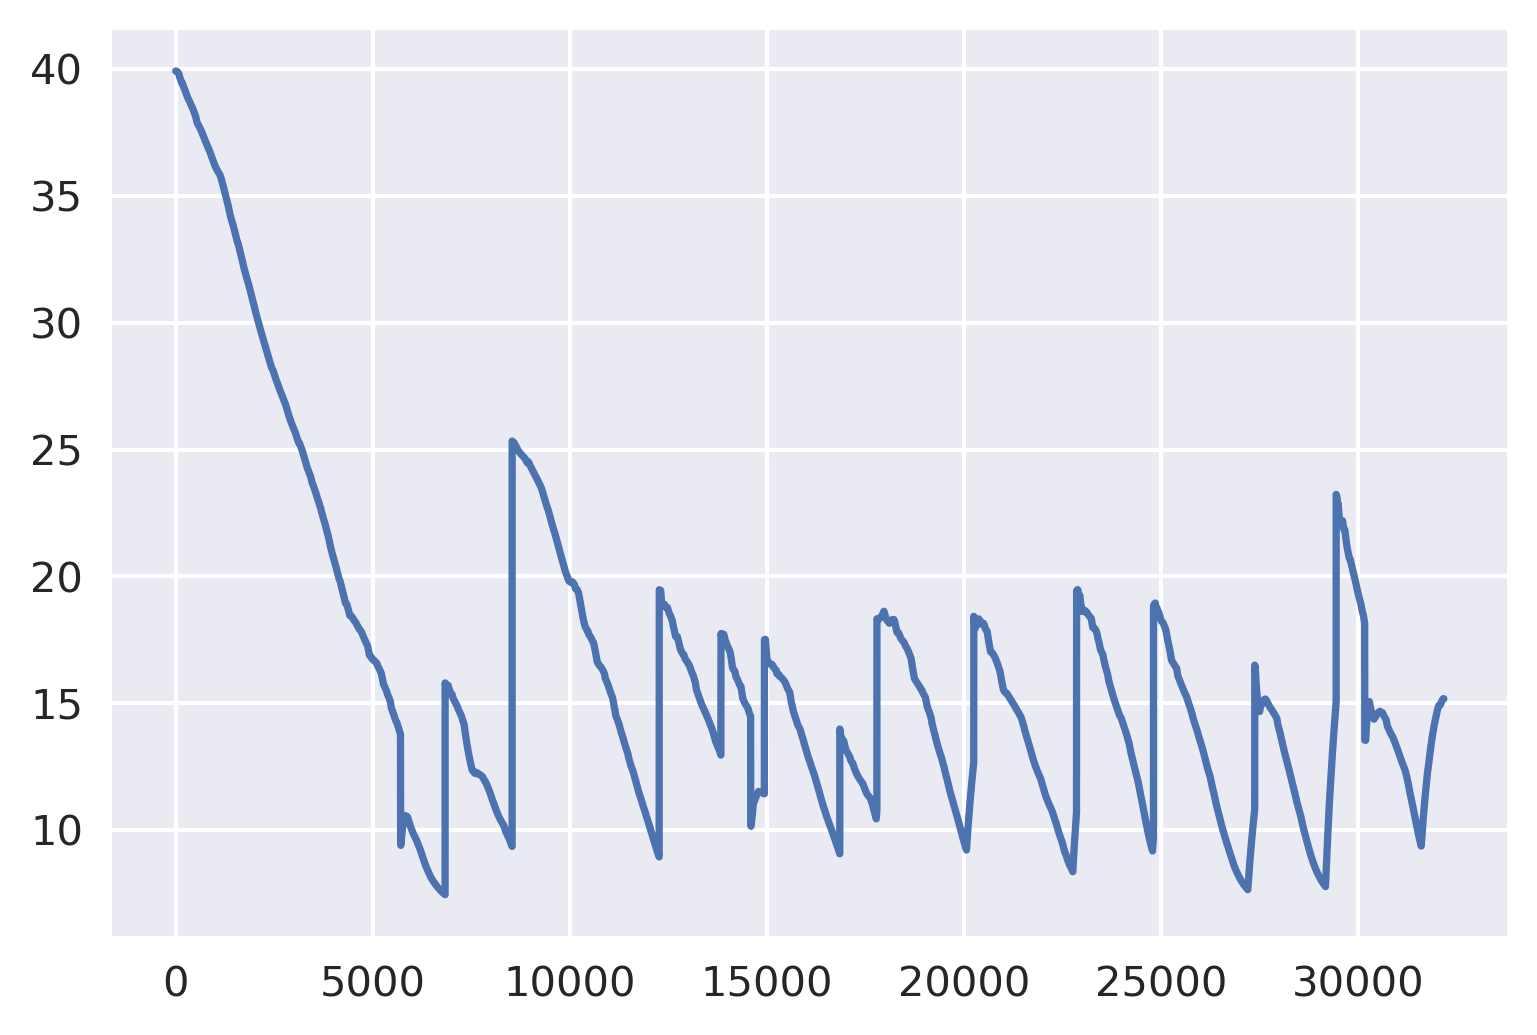

In [15]:
## Applying kalman Filter 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import namedtuple 
from ipywidgets import interact

# mpl.rcParams['figure.figsize'] = (20,10)

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, š={:.3f})'.format(s[0], s[1])


fuel = np.array(df['fuel_litre'])
engine = np.array(df['engine_status'])

#fuel = np.flip(fuel, axis=0)

# plt.plot(fuel)

def gaussian_multiply(g1,g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean)/(g1.var+g2.var)
    variance = (g1.var*g2.var)/(g1.var+g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)


sensor_var_noise = 2.**2
process_var_noise = 25.**2
sensor_var_clean = 16.**2
process_var_clean = .04**2

process_var = 0.01
sensor_var = 10.**2 	#SD 50 - 68% of values will be within X +/- 50 
velocity = 0
dt = 1.

process_model = gaussian(velocity*dt, process_var)

x = gaussian(fuel[0], 50**2)
updated = []
loop = 0
flag = 0
m = fuel[0]
for i,z in enumerate(fuel):
    curr_eng = engine[i]
    prev_eng = engine[i-1]
    if curr_eng - prev_eng == 1 and abs(z-m)>4:
        if 0.0 < np.var(fuel[i:i+10]) < 0.5:
            loop = 1
#         loop = 1
    if loop > 0:
        sensor_var = sensor_var_noise
        process_var = process_var_noise
        loop -= 1
    elif loop == 0:
        sensor_var = sensor_var_clean
        process_var = process_var_clean
    process_model = gaussian(velocity*dt, process_var)
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    m,s = x 
    updated.append(m)

# plt.hold()
plt.plot(updated)
    
# interact(kf_apply,SensorVarNoise=(0,50,5),ProcessVarNoise=(0,50,5),SensorVarClean=(1,50,5),ProcessVarClean=(0.01,0.1,0.01))